In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# %reload_ext autoreload

In [10]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.io as io

import filters
import homography
import rectification
import utils
import mops

In [11]:
im1 = utils.read_img("data/plush1.jpg")
im2 = utils.read_img("data/plush2.jpg")
im1_gray = utils.read_img("data/plush1.jpg", gray=True)
im2_gray = utils.read_img("data/plush2.jpg", gray=True)

/Users/aprilsin/GitHub/cs194-proj5/mops.py:25: FutureWarning: Until version 0.16, threshold_rel was set to 0.1 by default. Starting from version 0.16, the default value is set to None. Until version 0.18, a None value corresponds to a threshold value of 0.1. The default behavior will match skimage.feature.peak_local_max. To avoid this warning, set threshold_rel=0.
  coords = corner_peaks(h, min_distance=2, indices=True)


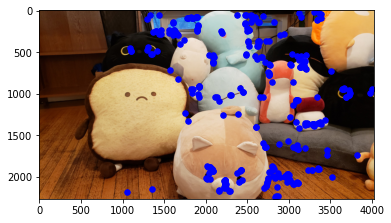

NameError: name 'harris' is not defined

In [13]:
stength1, corners1 = mops.get_corners(im1_gray)
utils.plot_pts(im1, corners1)
c1 = mops.detect_corners(im1)
utils.plot_pts(im1, corners2)
utils.plot_pts(im1, c1)
# stength2, corners2 = harris.get_corners(im2_gray)

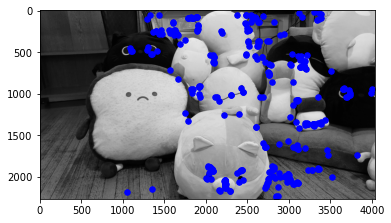

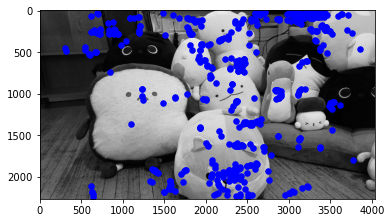

In [35]:
stength1, corners1 = harris.get_corners(im1_gray)
utils.plot_pts(im1, corners1)
c1 = mops.detect_corners(im1)
utils.plot_pts(im1, corners2)
utils.plot_pts(im1, c1)
# stength2, corners2 = harris.get_corners(im2_gray)

In [ ]:
# Do Adaptive Non-Maximal Suppression